In [17]:
import torch
# For dataset preparation
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
# For building neural networks
import torch.nn as nn
import torch.nn.functional as F
# For training
from torch.optim import SGD, Adam

# Preparing the dataset

In [2]:
training_data = datasets.MNIST(
    # Where the data are stored. If this is a relative path, 
    # the path is assumed to start from the current working directory. 
    # Therefore you can find a data folder coming together with this notebook.
    root="./data",  
    train=True, 
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64
training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Defining the model

Below is the shape of each image in the training dataset:
we have one "channel" which is used probably used for CNN models.

In [4]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [5]:
class EncoderMLP(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dim)
        
    def forward(self, xb):
        # Since we are not defining a CNN, 
        # we just ignore the channel dimension 
        # and collapse everything into one dimension.
        # Note that the first index i.e. index 0 is the batch index
        xb = torch.flatten(xb, start_dim=1)
        xb = self.linear1(xb)
        xb = F.relu(xb)
        xb = self.linear2(xb)
        return xb

The structure of the decoder, in our simple demo,
is exactly the opposite to that of the encoder.
But the activation function is different:
we need sigmoid to make sure the output is properly normalized.

In [6]:
class DecoderMLP(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, xb):
        xb = self.linear1(xb)
        xb = F.sigmoid(xb)
        xb = self.linear2(xb)
        # Make sure the shape of the output tensor looks the same as 
        # that of the input data.
        # Since xb in the last step has the batch dimension as the first dimension. 
        xb = torch.reshape(xb, (-1, 1, 28, 28)) 
        return xb

We still need to glue the encoder and the decoder together into the shape of an hourglass.

In [7]:
class AutoencoderMLP(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = EncoderMLP(latent_dim)
        self.decoder = DecoderMLP(latent_dim)
        
    def forward(self, xb):
        z = self.encoder(xb)
        return self.decoder(z)

# Training

See whether CUDA is needed.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

We define the model here:

In [ ]:
latent_dim = 2 
ae = AutoencoderMLP(latent_dim)
ae = ae.to(device)

In [ ]:
def train(model, dataloader, lr, epoches):
    optimizer = SGD(model.parameters(), lr=lr)
    for epoch in range(epoches):
        model.train()
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            Xhat = model(X) 
            loss = ((X - Xhat)**2).sum()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval() 
        with torch.no_grad():
            for X, Y in test_dataloader:
                X = X.to(device)
                Y = Y.to(device)
                
                Xhat = model(X) 
                loss = ((X - Xhat)**2).mean().item()

                print(f"epoch {epoch:>3d}   test loss avg: {loss:>5f}")

In [ ]:
train(ae, training_dataloader, lr=0.002, epoches=5)

epoch   0   test loss avg: 0.067564
epoch   1   test loss avg: 0.067558
epoch   2   test loss avg: 0.067602
epoch   3   test loss avg: 0.067572
epoch   4   test loss avg: 0.067647


# Checking if the autoencoder works well

In [13]:
import matplotlib.pyplot as plt

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


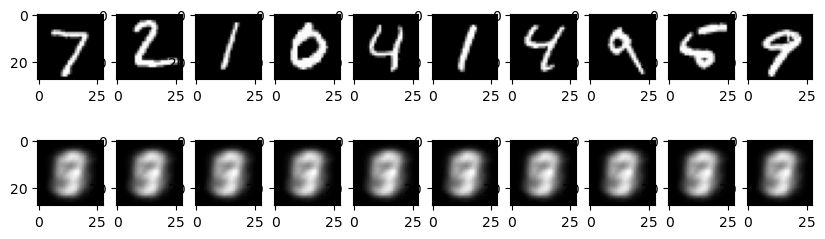

In [ ]:
for x, y in test_dataloader:
    break

x = x.to(device)
xb = ae(x)

x = x.to("cpu")
xb = xb.to("cpu")

print(x.size())
print(xb.size())

with torch.no_grad():
    idxs = range(0, 10)
    fig, axes = plt.subplots(2, len(idxs), figsize=(10, 3))
    for i, img_idx in enumerate(idxs):
        axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
        axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
        
    plt.show()

So it seems it doesn't work well enough.

# Improvement: CNN

As a first improvement, let's replace MLP by CNN.

In [ ]:
class AutoencoderCNN(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # To simply the code, let's use Sequential to define the encoder and the decoder,
        # instead of define a  
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, 7, 7]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1), # [batch, 16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  # [batch, 1, 28, 28]
            nn.Sigmoid(),  # for pixel values between 0 and 1
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed


In [ ]:
# Let's try to check if AutoencoderCNN works

model = AutoencoderCNN(32)
res = model(training_data[0][0].unsqueeze(0))
print(res[0].size())
print(res[1].size())

torch.Size([1, 32, 7, 7])
torch.Size([1, 1, 28, 28])


In [18]:
def train(model, dataloader, lr, epoches):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epoches):
        model.train()
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            Xhat = model(X)[1]
            loss = criterion(X, Xhat)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval() 
        with torch.no_grad():
            for X, Y in test_dataloader:
                X = X.to(device)
                Y = Y.to(device)
                
                Xhat = model(X)[1]
                loss = criterion(X, Xhat)

                print(f"epoch {epoch:>3d}   test loss avg: {loss:>5f}")

In [19]:
model = model.to("cuda")
train(model, training_dataloader, lr=0.002, epoches=5)

epoch   0   test loss avg: 0.000837
epoch   1   test loss avg: 0.000593
epoch   2   test loss avg: 0.000485
epoch   3   test loss avg: 0.000440
epoch   4   test loss avg: 0.000390


torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


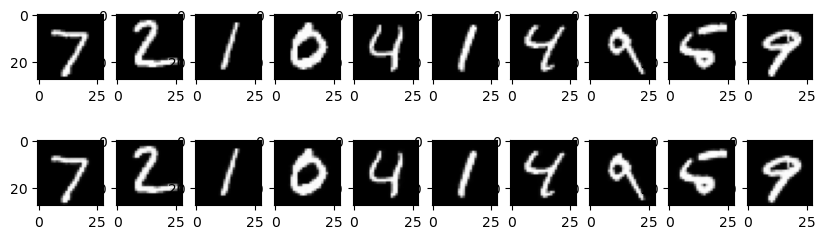

In [20]:
for x, y in test_dataloader:
    break

x = x.to(device)
xb = model(x)[1]

x = x.to("cpu")
xb = xb.to("cpu")

print(x.size())
print(xb.size())

with torch.no_grad():
    idxs = range(0, 10)
    fig, axes = plt.subplots(2, len(idxs), figsize=(10, 3))
    for i, img_idx in enumerate(idxs):
        axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
        axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
        
    plt.show()

Note that the learning rate is to be fine tuned.
Otherwise the results will be disastrous.

# Variational autoencoder (VAE)

It is possible - but hard - to fine tune the training process of vanilla autoencoder.
A much more robust variant of AE is variational autoencoder,
which utilizes variational inference.

The exact way it works is too long to be narrated here. 
We just provide a working example.

In [ ]:
class VAE()